# **Comparison of GloFAS and FloodHub**

In [1]:
import pandas as pd
import geopandas as gpd

In [23]:
# 510 colour codes
red = '#DB0A13'
blue = '#092448'

#### **Plot both on a point-to-point basis**

For the point-to-point match, every GloFAS station is matched with the nearest FloodHub station, measured in absolute Euclidian distance. Partly because there are far more evaluable GloFAS locations than for FloodHub, the plots will inevitably show duplicate FloodHub forecasts. The plots are carried out by:
- importing the point-to-point matching data;
- importing the corresponding GloFAS data;
- importing and subsetting the corresponding Google data;
- define a function that extracts, based on a given time period and (point-)location, the desired data; and
- define a function that uses the extracted data for a lineplot.

In [2]:
df_point_match_GloFAS_to_GFH = pd.read_csv(
    'data/point_matches/mali_pm_GloFAS_left_joined.csv',
    index_col = None,
    sep = ',',
    decimal = '.',
    encoding = 'utf-8'
)

print(df_point_match_GloFAS_to_GFH.head(2))

  StationName  StationName_x  StationName_y           gaugeId  gaugeId_x  \
0     Tossaye        -3.1796        16.4157  hybas_1120641660   -4.20625   
1    Koryoume        -3.0333        16.6666  hybas_1120641660   -4.20625   

   gaugeId_y  
0   14.50625  
1   14.50625  


In [3]:
df_points_GloFAS_forecasts = pd.read_csv(
    'data/forecasts/aggregatedGloFAS.csv',
    index_col = 0,
    sep = ',',
    decimal = '.',
)
df_points_GloFAS_forecasts.index = pd.to_datetime(
    df_points_GloFAS_forecasts.index,
    format = '%d/%m/%Y'
)
print(df_points_GloFAS_forecasts.head(2))

             Tossaye  Koryoume   Goundam      Dire     Tonka  Sarafere  \
2024-06-26  0.140625  3.171875  2.937500  0.046875  0.078125  1.515625   
2024-06-27  0.140625  3.156250  2.921875  0.046875  0.078125  1.515625   

             Ansongo      Akka     Kayes    Kabate  ...       Gao  Pankourou  \
2024-06-26  0.140625  0.296875  0.296875  0.140625  ...  2.015625        NaN   
2024-06-27  0.140625  0.296875  0.296875  0.140625  ...  2.015625        NaN   

            Bamako  Diangola  Niger A Kenieroba  Guelelinkoro  Mahina  \
2024-06-26     NaN       NaN                NaN           NaN     NaN   
2024-06-27     NaN       NaN                NaN           NaN     NaN   

                  Douna      Kana  Baoule At Madina Diassa  
2024-06-26  21632.78125  3.140625                      NaN  
2024-06-27  21552.75000  3.140625                      NaN  

[2 rows x 47 columns]


In [4]:
df_points_GFH_forecasts = pd.read_csv(
    # For now, get it from the GoogleFloodHub directory
    # data location; later on, everything will have to be merged
    '../GoogleFloodHub/data/floods_data/mali/2024-07-08_to_2024-11-13.csv',
    index_col = 0,
    sep = ';',
    decimal = '.'
)
print(df_points_GFH_forecasts.head(2))

            gaugeId  issue_date                        issue_time     fc_date  \
0  hybas_1120641660  2024-07-08  2024-07-08 13:54:03.433896+00:00  2024-07-07   
1  hybas_1120641660  2024-07-08  2024-07-08 13:54:03.433896+00:00  2024-07-08   

     fc_value  
0  238.515350  
1  247.505783  


In [ ]:
from typing import List, Tuple
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


def set_TeX_style() -> None:
    """
    Sets the style environment for the plots to use TeX for text rendering
    """
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern Serif",
        "axes.labelsize": 10,     # fontsize for x and y labels
        "xtick.labelsize": 10,    # fontsize of the tick labels
        "ytick.labelsize": 10,    # fontsize of the tick labels
        "legend.fontsize": 10,    # fontsize of the legen
    })


def set_plot_style(
        TeX: bool = False, style: str = 'ticks', context: str = None) -> None:
    """
    Sets the style environment for the plots, including:
    - through the set_TeX_style function:
        - whether to use TeX for text rendering
        - the font family for titles, labels, etc.
        - the font size for titles, labels, etc.
    - seaborn style to use (default = 'ticks')
    - the context for the plot (default = 'notebook')
    
    :param TeX: whether to use TeX for text rendering
    :param style: seaborn style to use
    :param context: the context for the plot
    """
    if TeX:
        set_TeX_style()
    sns.set_theme(style = 'ticks')
    sns.set_context(context) if context else None


def normalise_dates(dt: Tuple[dt.datetime, dt.datetime]) -> None:
    """
    Normalises the dates in the given tuple, so that:
    - the first date comes first; and
    - the more-than-daily information is removed

    :param dt: Tuple with the start and end of the time interval
    """
    start, end = dt
    start = start.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    end = end.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    if start == end:
        end += dt.timedelta(days = 7)
    if start > end:
        return (dt[1], dt[0])
    return (dt[0], dt[1])

    
def get_gauge_ID(df_point_match: pd.DataFrame, point_id: str) -> str:
    """
    Gets the gauge ID for the given point ID

    :param df_point_match: DataFrame with the point matches
    :param point_id: ID of the point to get the gauge ID for
    :return: Gauge ID for the given point ID
    """
    return df_point_match[
        df_point_match['StationName'] == point_id
    ]['gaugeId'].values[0]


def create_dates_list(start: dt.datetime, end: dt.datetime) -> List[str]:
    """
    Creates a list of dates between the start and end dates

    :param start: start date
    :param end: end date
    :return: list of str dates (e.g. '2024-11-13') between the start and end date
    """
    dates = [start + dt.timedelta(days = idx) for idx in range((end - start).days)]
    return [date.strftime('%Y-%m-%d') for date in dates]


def make_subset_of_issue_date(df:pd.DataFrame, issue_date: dt.datetime) -> pd.DataFrame:
    """
    Makes a subset of the DataFrame for the given issue date

    :param df: DataFrame to make the subset of
    :param issue_date: issue date to make the subset for
    :return: DataFrame subset for the given issue date
    """
    return df[df['issue_date'] == issue_date].reset_index(drop = True)


def get_GloFAS_and_GFH_data_for_point_and_dt(
    df_point_match: pd.DataFrame,
    df_forecasts_GloFAS: pd.DataFrame,
    df_forecasts_GFH: pd.DataFrame,
    station_id: str,
    dt: Tuple[dt.datetime, dt.datetime]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Gets a dataframe which matches GloFAS points to GoogleFloodHub points,
    meaning that the GloFAS points are matched to the nearest GoogleFloodHub
    points, plus a dataframe with forecasts from both (which need to be
    handled separately and independently), and returns the forecasts for
    the given point_id and time_delta

    :param df_point_match: DataFrame with the point matches
    :param df_forecasts_GloFAS: DataFrame with the GloFAS forecasts
    :param df_forecasts_GFH: DataFrame with the GoogleFloodHub forecasts
    :param station_id: ID of the point/GloFAS station to get the forecasts for
    :param dt: Tuple time delta/interval to get the forecasts for
    :return: Tuple with the GloFAS and GoogleFloodHub forecasts
    """
    dt = normalise_dates(dt)
    dt = create_dates_list(dt[0], dt[1])
    gauge_ID = get_gauge_ID(df_point_match, station_id)

    df_forecasts_GloFAS_subset = df_forecasts_GloFAS[station_id][dt[0]:dt[-1]]
    df_forecasts_GFH_subset = df_forecasts_GFH[
        (df_forecasts_GFH['gaugeId'] == gauge_ID) &
        (df_forecasts_GFH['issue_date'].isin(dt))
    ]

    # print(df_forecasts_GloFAS_subset.head(2))
    # print(df_forecasts_GloFAS_subset.tail(2))
    # print(df_forecasts_GFH_subset.head(2))
    # print(df_forecasts_GFH_subset.tail(2))

    if df_forecasts_GloFAS_subset.empty:
        print('No GloFAS forecasts for the given point and time interval')
        return None, None
    if df_forecasts_GFH_subset.empty:
        print('No GoogleFloodHub forecasts for the given point and time interval')
        return None, None
    
    return df_forecasts_GloFAS_subset, df_forecasts_GFH_subset


def plot_point_over_dt(
    df_point_match: pd.DataFrame,
    df_forecasts_GloFAS: pd.DataFrame,
    df_forecasts_GFH: pd.DataFrame,
    station_id: str,
    dt: Tuple[dt.datetime, dt.datetime]
) -> None:
    """
    Plots the GloFAS and GoogleFloodHub forecasts for the given point
    over the given time interval

    :param df_point_match: DataFrame with the point matches
    :param df_forecasts_GloFAS: DataFrame with the GloFAS forecasts
    :param df_forecasts_GFH: DataFrame with the GoogleFloodHub forecasts
    :param station_id: ID of the point/GloFAS station to get the forecasts for
    :param dt: Tuple time delta/interval to get the forecasts
    """                             
    df_GloFAS, df_GFH = get_GloFAS_and_GFH_data_for_point_and_dt(
        df_point_match,
        df_forecasts_GloFAS,
        df_forecasts_GFH,
        station_id,
        dt
    )

    set_plot_style()
    fig, ax = plt.subplots(figsize = (12, 6))

    # First, add GloFAS lineplot
    sns.lineplot(
        x = df_GloFAS.index,
        y = df_GloFAS,
        ax = ax,
        color = blue,
        label = 'GloFAS'
    )

    # Then, add GHH lineplots
    first_plot = True
    for issue_date in create_dates_list(dt[0], dt[1]):
        df_GFH_subset = make_subset_of_issue_date(df_GFH, issue_date)
                                    # for x-axis (type) alignment
        df_GFH_subset['fc_date'] = mdates.date2num(df_GFH_subset['fc_date'])

        sns.lineplot(
            x = df_GFH_subset['fc_date'],
            y = df_GFH_subset['fc_value'],
            ax = ax,
            color = red,
            label = 'FloodHub' if first_plot else None
        )
        first_plot = False


    ax.set_xlabel('date')
    ax.set_ylabel(f'discharge (m$^3$/s) at {station_id}')
    ax.legend()
    plt.show()

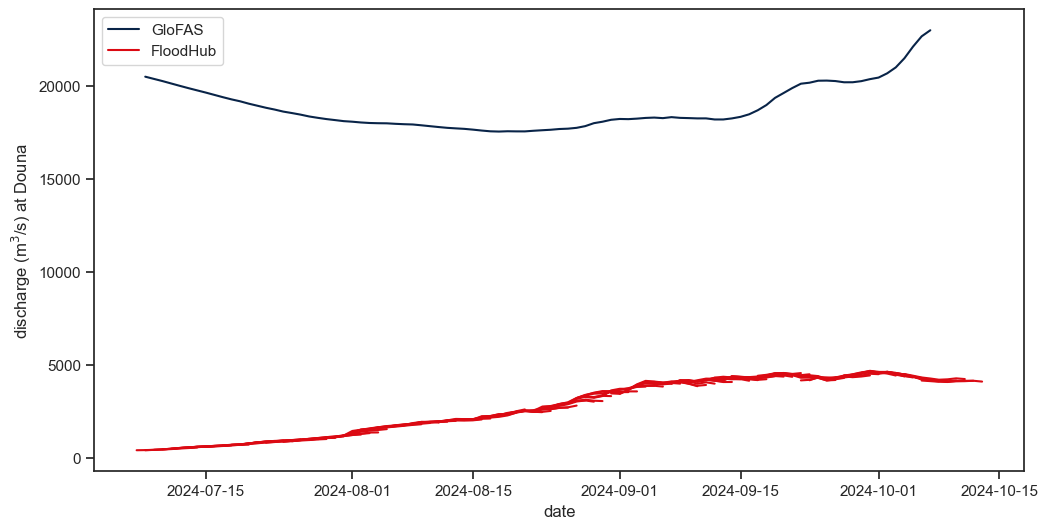

In [34]:
plot_point_over_dt(
    df_point_match_GloFAS_to_GFH,
    df_points_GloFAS_forecasts,
    df_points_GFH_forecasts,
    'Douna',
    (dt.datetime(2024, 7, 8), dt.datetime(2024, 10, 8))
)

#### **Plot maximum per administrative unit per model over time**

Because the intend of the comparison is to see which model would fit in a practical setting, the comparison is conducted as if the models are "operational" within the IBF-system; that is, we calculate the aggregated value a model gives per administrative unit, and use that for comparison. Here, some information is lost, but practicality is gained.

The method for determining this "value" or "maximum" is still to be discussed, and will be calculated below when determined.